In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")

In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]
eval_data = eval_data[:int(len(eval_data)/2)]
eval_label = eval_label[:int(len(eval_label)/2)]
idx = 0

In [ ]:
from tensorflow.keras.utils import to_categorical

enc_labels = to_categorical(eval_label, num_classes=2)              
test_label = to_categorical(test_label, num_classes=2)              
eval_label= enc_labels
enc_labels = 0
print(eval_data.shape)
print(eval_label.shape)
print(eval_data.dtype)
print(eval_label.dtype)
print('training labels have been loaded')

bs,t,f = eval_data.shape

(1741, 22, 15000)
(1741, 2)
float32
float32
training labels have been loaded


In [ ]:
from pdb import set_trace
#import mne
import pandas as pd
import numpy as np
import math
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------SHALLOW-NET Testing-----------------------
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Conv2D
from tensorflow.keras.models import Model

inputsin= Input(shape=(t,f))


# ------------------First Inception
shallow_net = Conv1D(40, 25, strides=1, activation='relu',padding="causal")(inputsin)
shallow_net = Flatten()(shallow_net)
predictions = Dense(2,activation='softmax')(shallow_net)


shallow_model = Model(inputs=inputsin, outputs=predictions)


# learning rate to 0.00001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

shallow_model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
print(shallow_model.metrics_names)
print(shallow_model.summary())

# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, mode='min', verbose=1, patience=25)                          #patience
mc = ModelCheckpoint('shallow_model3flipped_acc.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)        #filepath (save model as)
mces = ModelCheckpoint('shallow_model3flipped_loss.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)      #filepath (save model as)

# fit model
# hist=shallow_model.fit(eval_data,eval_label,validation_split=0.2,epochs=10,batch_size=128,verbose=1,callbacks=[es, mc,mces],shuffle=True) #epochs #split #
print('The End')

[]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 40)            15000040  
_________________________________________________________________
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1762      
Total params: 15,001,802
Trainable params: 15,001,802
Non-trainable params: 0
_________________________________________________________________
None
The End


In [ ]:

hist=shallow_model.fit(eval_data,eval_label,validation_data=(test_data, test_label),epochs=10,batch_size=32,verbose=1,callbacks=[es, mc,mces],shuffle=True) #epochs #split #


Epoch 1/10
55/55 [==============================] - 37s 83ms/step - loss: 0.6631 - accuracy: 0.5738 - val_loss: 0.7214 - val_accuracy: 0.5667

Epoch 00001: val_loss improved from inf to 0.72137, saving model to shallow_model3flipped_loss.hdf5
Epoch 2/10
55/55 [==============================] - 3s 59ms/step - loss: 0.2059 - accuracy: 0.9741 - val_loss: 0.6911 - val_accuracy: 0.5500

Epoch 00002: val_loss improved from 0.72137 to 0.69109, saving model to shallow_model3flipped_loss.hdf5
Epoch 3/10
55/55 [==============================] - 3s 60ms/step - loss: 0.1212 - accuracy: 0.9980 - val_loss: 0.6754 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.69109 to 0.67536, saving model to shallow_model3flipped_loss.hdf5
Epoch 4/10
55/55 [==============================] - 3s 59ms/step - loss: 0.0847 - accuracy: 1.0000 - val_loss: 0.6659 - val_accuracy: 0.6500

Epoch 00004: val_loss improved from 0.67536 to 0.66593, saving model to shallow_model3flipped_loss.hdf5
Epoch 5/10
55/55 [=

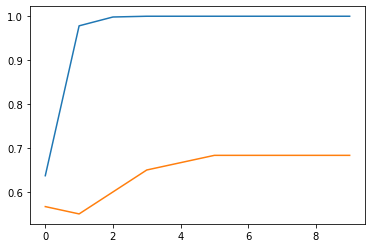

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

In [ ]:
         
test_label = to_categorical(test_label, num_classes=2)     

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(shallow_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("")
#tflite_models_dir.mkdir(exist_ok=True, parents=True)
'''
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
'''
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

In [ ]:
tflite_interpreter = tf.lite.Interpreter('model_quant.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()


#tflite_interpreter.resize_tensor_input(input_details[0]['index'], (60, 22, 15000))
#tflite_interpreter.resize_tensor_input(output_details[0]['index'], (60, 2))
tflite_interpreter.allocate_tensors()


predictions = []
for data in test_data:
  tflite_interpreter.set_tensor(input_details[0]['index'], [data])

  tflite_interpreter.invoke()

  tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
  print("Prediction results shape:", tflite_model_predictions.shape)
  predictions.append(tflite_model_predictions)

In [ ]:
count = 0
for i in range(len(predictions)):
  if (predictions[i][0][0] > predictions[i][0][1]) and (test_label[i][0] == 1):
    count += 1
  elif (predictions[i][0][0] < predictions[i][0][1]) and (test_label[i][1] == 1):
    count += 1
print(f'total correct predictions = {count}')
print(f'accuracy = {count/60}')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(shallow_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model_f = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("")
#tflite_models_dir.mkdir(exist_ok=True, parents=True)
'''
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
'''
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant_f.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model_f)

In [ ]:
tflite_interpreter = tf.lite.Interpreter('model_quant_f.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()


#tflite_interpreter.resize_tensor_input(input_details[0]['index'], (60, 22, 15000))
#tflite_interpreter.resize_tensor_input(output_details[0]['index'], (60, 2))
tflite_interpreter.allocate_tensors()


predictions = []
for data in test_data:
  tflite_interpreter.set_tensor(input_details[0]['index'], [data])

  tflite_interpreter.invoke()

  tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
  print("Prediction results shape:", tflite_model_predictions.shape)
  predictions.append(tflite_model_predictions)

In [ ]:
count = 0
for i in range(len(predictions)):
  if (predictions[i][0][0] > predictions[i][0][1]) and (test_label[i][0] == 1):
    count += 1
  elif (predictions[i][0][0] < predictions[i][0][1]) and (test_label[i][1] == 1):
    count += 1
print(f'total correct predictions = {count}')
print(f'accuracy = {count/60}')

# Pruning 50 %

In [ ]:
shallow_model.load_weights("/content/shallow_model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(shallow_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
prune_low_magnitude_conv1d ( (None, 22, 40)            30000042  
_________________________________________________________________
prune_low_magnitude_flatten  (None, 880)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 2)                 3524      
Total params: 30,003,567
Trainable params: 15,001,802
Non-trainable params: 15,001,765
_________________________________________________________________


In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
14/14 [==============================] - 41s 443ms/step - loss: 1.8013 - accuracy: 0.7606 - val_loss: 2.1342 - val_accuracy: 0.7333
Epoch 2/10
14/14 [==============================] - 3s 185ms/step - loss: 0.5757 - accuracy: 0.9377 - val_loss: 3.0913 - val_accuracy: 0.7333
Epoch 3/10
14/14 [==============================] - 3s 185ms/step - loss: 0.0291 - accuracy: 0.9932 - val_loss: 3.0252 - val_accuracy: 0.7500
Epoch 4/10
14/14 [==============================] - 3s 187ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 2.8163 - val_accuracy: 0.7167
Epoch 5/10
14/14 [==============================] - 3s 183ms/step - loss: 6.0539e-04 - accuracy: 1.0000 - val_loss: 2.8110 - val_accuracy: 0.7333
Epoch 6/10
14/14 [==============================] - 3s 184ms/step - loss: 2.7891e-04 - accuracy: 1.0000 - val_loss: 2.8072 - val_accuracy: 0.7333
Epoch 7/10
14/14 [==============================] - 3s 191ms/step - loss: 2.1088e-04 - accuracy: 1.0000 - val_loss: 2.7716 - val_accuracy: 

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(deep_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmplwirb7rr.h5
Size of gzipped pruned Keras model: 40422684.00 bytes


# Pruning 60 %

In [ ]:
shallow_model.load_weights("/content/shallow_model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                               final_sparsity=0.60,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(shallow_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
prune_low_magnitude_conv1d ( (None, 22, 40)            30000042  
_________________________________________________________________
prune_low_magnitude_flatten  (None, 880)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 2)                 3524      
Total params: 30,003,567
Trainable params: 15,001,802
Non-trainable params: 15,001,765
_________________________________________________________________


In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
14/14 [==============================] - 41s 452ms/step - loss: 2.2186 - accuracy: 0.7348 - val_loss: 2.6523 - val_accuracy: 0.7000
Epoch 2/10
14/14 [==============================] - 3s 193ms/step - loss: 0.5342 - accuracy: 0.9428 - val_loss: 2.6064 - val_accuracy: 0.8000
Epoch 3/10
14/14 [==============================] - 3s 188ms/step - loss: 0.0532 - accuracy: 0.9901 - val_loss: 2.5122 - val_accuracy: 0.8333
Epoch 4/10
14/14 [==============================] - 3s 199ms/step - loss: 0.0213 - accuracy: 0.9971 - val_loss: 2.4049 - val_accuracy: 0.8333
Epoch 5/10
14/14 [==============================] - 3s 179ms/step - loss: 9.4903e-04 - accuracy: 1.0000 - val_loss: 2.3239 - val_accuracy: 0.8167
Epoch 6/10
14/14 [==============================] - 3s 183ms/step - loss: 5.6132e-04 - accuracy: 1.0000 - val_loss: 2.3081 - val_accuracy: 0.8167
Epoch 7/10
14/14 [==============================] - 3s 200ms/step - loss: 4.5933e-04 - accuracy: 1.0000 - val_loss: 2.2698 - val_accuracy: 

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(deep_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpgzb95bp0.h5
Size of gzipped pruned Keras model: 37586108.00 bytes


#Prunning 70%

In [ ]:
shallow_model.load_weights("/content/shallow_model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(shallow_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
prune_low_magnitude_conv1d ( (None, 22, 40)            30000042  
_________________________________________________________________
prune_low_magnitude_flatten  (None, 880)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 2)                 3524      
Total params: 30,003,567
Trainable params: 15,001,802
Non-trainable params: 15,001,765
_________________________________________________________________


In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
14/14 [==============================] - 41s 459ms/step - loss: 1.6063 - accuracy: 0.7532 - val_loss: 5.0479 - val_accuracy: 0.6667
Epoch 2/10
14/14 [==============================] - 3s 187ms/step - loss: 0.4828 - accuracy: 0.9500 - val_loss: 4.6643 - val_accuracy: 0.6333
Epoch 3/10
14/14 [==============================] - 3s 196ms/step - loss: 0.0622 - accuracy: 0.9886 - val_loss: 4.2536 - val_accuracy: 0.6833
Epoch 4/10
14/14 [==============================] - 3s 190ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 4.0990 - val_accuracy: 0.7167
Epoch 5/10
14/14 [==============================] - 3s 188ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.9654 - val_accuracy: 0.7333
Epoch 6/10
14/14 [==============================] - 3s 177ms/step - loss: 7.1490e-04 - accuracy: 1.0000 - val_loss: 3.8032 - val_accuracy: 0.7333
Epoch 7/10
14/14 [==============================] - 3s 191ms/step - loss: 5.5246e-04 - accuracy: 1.0000 - val_loss: 3.7120 - val_accuracy: 0.73

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(deep_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpjj2do8lu.h5
Size of gzipped pruned Keras model: 32659064.00 bytes


# Pruning 80%

In [ ]:
shallow_model.load_weights("/content/shallow_model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(shallow_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
prune_low_magnitude_conv1d ( (None, 22, 40)            30000042  
_________________________________________________________________
prune_low_magnitude_flatten  (None, 880)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 2)                 3524      
Total params: 30,003,567
Trainable params: 15,001,802
Non-trainable params: 15,001,765
_________________________________________________________________


In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

Epoch 1/10
14/14 [==============================] - 40s 389ms/step - loss: 1.5743 - accuracy: 0.7511 - val_loss: 3.1712 - val_accuracy: 0.6833
Epoch 2/10
14/14 [==============================] - 3s 190ms/step - loss: 0.4072 - accuracy: 0.9548 - val_loss: 3.0713 - val_accuracy: 0.6667
Epoch 3/10
14/14 [==============================] - 3s 190ms/step - loss: 0.0801 - accuracy: 0.9891 - val_loss: 2.9333 - val_accuracy: 0.7500
Epoch 4/10
14/14 [==============================] - 3s 197ms/step - loss: 0.0122 - accuracy: 0.9990 - val_loss: 2.6711 - val_accuracy: 0.7667
Epoch 5/10
14/14 [==============================] - 3s 181ms/step - loss: 9.3718e-04 - accuracy: 1.0000 - val_loss: 2.5534 - val_accuracy: 0.7833
Epoch 6/10
14/14 [==============================] - 3s 180ms/step - loss: 6.5595e-04 - accuracy: 1.0000 - val_loss: 2.4236 - val_accuracy: 0.7667
Epoch 7/10
14/14 [==============================] - 3s 199ms/step - loss: 9.5514e-04 - accuracy: 1.0000 - val_loss: 2.3527 - val_accuracy: 

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(deep_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Saved pruned Keras model to: /tmp/tmpjywxl205.h5
Size of gzipped pruned Keras model: 29627197.00 bytes


# Pruning 90%

In [ ]:
shallow_model.load_weights("/content/shallow_model3flipped_loss.hdf5")


!pip install tensorflow_model_optimization
is_tfmot = True


if not(is_tfmot):
  !pip install tensorflow_model_optimization
  is_tfmot = True

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = eval_data.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=5)
}

model_for_pruning = prune_low_magnitude(shallow_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

hist = model_for_pruning.fit(eval_data, eval_label, validation_data=(test_data, test_label), epochs=10, batch_size=128, verbose=1, callbacks=callbacks) #epochs #split #

In [ ]:

import tempfile
import os

import tensorflow as tf
import numpy as np

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', deep_pruned_keras_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(deep_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

NameError: ignored

In [ ]:

import tempfile
import os

import tensorflow as tf
import numpy as np

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


#model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, deep_pruned_keras_file = tempfile.mkstemp('.h5')
#tf.keras.models.save_model(model_for_export, deep_pruned_keras_file, include_optimizer=False)
#print('Saved pruned Keras model to:', deep_pruned_keras_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/shallow_model3flipped_loss.hdf5")))
#print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(deep_pruned_keras_file)))

model_for_export = 0

Size of gzipped baseline Keras model: 151541380.00 bytes
